Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras

## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

In [1]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [5]:
len(x_train[608])

170

In [6]:
print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [7]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [13]:
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [14]:
unicorns = model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=20, 
          validation_data=(x_test,y_test))


Epoch 1/20
782/782 [==============================] - 43s 56ms/step - loss: 0.4221 - accuracy: 0.8018 - val_loss: 0.3569 - val_accuracy: 0.8423
Epoch 2/20
782/782 [==============================] - 43s 55ms/step - loss: 0.2535 - accuracy: 0.8976 - val_loss: 0.4280 - val_accuracy: 0.8318
Epoch 3/20
782/782 [==============================] - 42s 54ms/step - loss: 0.1632 - accuracy: 0.9387 - val_loss: 0.4673 - val_accuracy: 0.8321
Epoch 4/20
782/782 [==============================] - 43s 55ms/step - loss: 0.1071 - accuracy: 0.9610 - val_loss: 0.4644 - val_accuracy: 0.8219
Epoch 5/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0748 - accuracy: 0.9738 - val_loss: 0.6757 - val_accuracy: 0.8187
Epoch 6/20
782/782 [==============================] - 42s 54ms/step - loss: 0.0526 - accuracy: 0.9820 - val_loss: 0.6661 - val_accuracy: 0.8227
Epoch 7/20
782/782 [==============================] - 43s 54ms/step - loss: 0.0410 - accuracy: 0.9861 - val_loss: 0.7177 - val_accuracy:

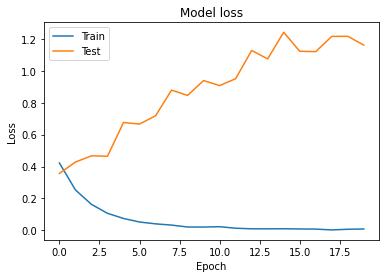

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

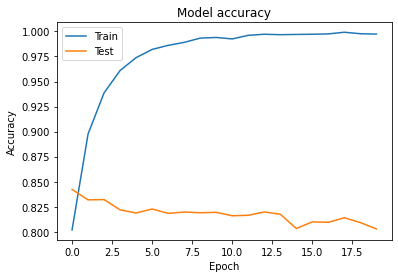

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['accuracy'])
plt.plot(unicorns.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [19]:
from tensorflow.keras.optimizers import Nadam

opt = Nadam(learning_rate=0.0001)

model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [20]:
unicorns = model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=20, 
          validation_data=(x_test,y_test))


Epoch 1/20
782/782 [==============================] - 41s 53ms/step - loss: 0.5464 - accuracy: 0.7142 - val_loss: 0.4416 - val_accuracy: 0.8014
Epoch 2/20
782/782 [==============================] - 42s 53ms/step - loss: 0.3611 - accuracy: 0.8474 - val_loss: 0.3758 - val_accuracy: 0.8296
Epoch 3/20
782/782 [==============================] - 41s 52ms/step - loss: 0.2966 - accuracy: 0.8768 - val_loss: 0.3663 - val_accuracy: 0.8340
Epoch 4/20
782/782 [==============================] - 41s 53ms/step - loss: 0.2524 - accuracy: 0.8993 - val_loss: 0.3690 - val_accuracy: 0.8341
Epoch 5/20
782/782 [==============================] - 41s 52ms/step - loss: 0.2226 - accuracy: 0.9122 - val_loss: 0.4718 - val_accuracy: 0.8182
Epoch 6/20
782/782 [==============================] - 41s 53ms/step - loss: 0.1949 - accuracy: 0.9264 - val_loss: 0.4330 - val_accuracy: 0.8271
Epoch 7/20
782/782 [==============================] - 40s 51ms/step - loss: 0.1760 - accuracy: 0.9354 - val_loss: 0.4103 - val_accuracy:

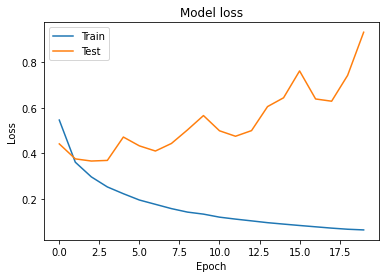

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

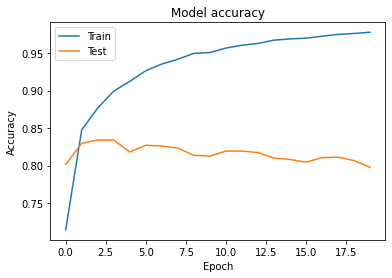

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['accuracy'])
plt.plot(unicorns.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [0]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import random
import sys
import os

In [24]:
data_files = os.listdir('./articles')

FileNotFoundError: ignored

In [25]:
# Read in Data

data = []

for file in data_files:
    if file[-3:] == 'txt':
        with open(f'./articles/{file}', 'r', encoding='utf-8') as f:
            data.append(f.read())

NameError: ignored

In [0]:
len(data)

136

In [0]:
data[-1]

'Here are some recent headlines from schools around the country: In Indiana, officials played a segment of a 911 call of a teacher in a panic during the Columbine High School shooting to students. In Ohio, officers fired blank shots during an active-shooter drill. In South Carolina, an officer dressed in black posed as an intruder on an unannounced drill. In Michigan, a school is spending $48 million on a renovation that includes curved hallways and hiding niches, in hopes of protecting students from a mass shooting. In Florida, a police officer arrested two 6-year-old students for misdemeanor battery. In Colorado, teachers received buckets and kitty litter for students to use as toilets in case of a prolonged school lockdown.\n\nMass shootings, meaning incidents with at least two deaths, in schools are horrifying. But it is highly unlikely that a child would ever witness one. Research indicates that some security measures brought in to make schools safer — like realistic shooter train

In [0]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later
text = " ".join(data)

# Unique Characters
chars = list(set(text))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [0]:
len(chars)

121

In [0]:
# Create the sequence data

maxlen = 40
step = 5

encoded = [char_int[c] for c in text]

sequences = [] # Each element is 40 chars long
next_char = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sequences.append(encoded[i : i + maxlen])
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences))


sequences:  178374


In [0]:
sequences[0]

[18,
 34,
 111,
 47,
 80,
 73,
 108,
 94,
 47,
 73,
 111,
 6,
 15,
 24,
 34,
 95,
 94,
 1,
 111,
 73,
 28,
 47,
 57,
 57,
 56,
 120,
 65,
 15,
 82,
 34,
 94,
 28,
 65,
 15,
 73,
 28,
 15,
 34,
 111,
 15]

In [0]:
# Create x & y

x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i,t,char] = 1
        
    y[i, next_char[i]] = 1
        

In [0]:
x.shape

(178374, 40, 121)

In [0]:
y.shape

(178374, 121)

In [0]:
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [0]:
# fit the model

model.fit(x, y,
          batch_size=32,
          epochs=10,
          callbacks=[print_callback])

Train on 178374 samples
Epoch 1/10
178368/178374 [============================>.] - ETA: 0s - loss: 2.5915
----- Generating text after Epoch: 0
----- Generating with seed: "n such changes are made, we will make a "
n such changes are made, we will make a deens enthint, rave and in megee s.. Ohe. AuH follis aso9 tuwhimg he erssing pounen arcendardass cfacents (used: prethirvand V ondey wiss afdiad bave siopeenS hes at,9e ptro ans ron anirB Connrmseadpar tion to thouth-ones bamavy andenof lyon unt resits seatior a. Ne thard aldeos’s o. Chins, Shemrace share ste, ina. “ITtrummer yom hig in wevire man rathonn.

AA Ceally gorluiex, caotren. Vof hali: w
178374/178374 [==============================] - 153s 860us/sample - loss: 2.5915
Epoch 2/10
178336/178374 [============================>.] - ETA: 0s - loss: 2.2482
----- Generating text after Epoch: 1
----- Generating with seed: " rivals. That’s when Pompeo lost his coo"
 rivals. That’s when Pompeo lost his coottal oss of ay thes a With exta

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 